# Analysis of Weather in Athens for the period 1955 - 2020
* This is a project created in the context of the course: "Applied Machine Learning".
* Data are obtained from:
    1. The National Oceanic and Atmospheric Administration's National Centers for Environmental Information (https://www.ncdc.noaa.gov/cdo-web/)
    2. The Helenic Data Service (https://hellenicdataservice.gr/main/)
* The analysis will be done on [Jupyter](http://jupyter.org/).
---
> Georgios Sideris <br />
> geosideris@aueb.gr

## Import packages
* To begin with, we will import the packages that we will use in the following segments of the project:
    * [NumPy](https://www.numpy.org/)
    * [pandas](https://pandas.pydata.org/)
    * [matplotlib](https://matplotlib.org/)
* Note the the prementioned packages **must be locally installed too** in order to be used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Obtain the Data
* The data used for the analysis can be found in the folder <code>data</code>:
    * <code>data/hellinikon_noaa.csv</code>: contains the data downloaded from [NOAA](https://www.ncdc.noaa.gov/cdo-web/).
    * <code>data/athens_hds.csv</code>: contains the data downloaded from [HDS](https://hellenicdataservice.gr/main/).
* We will talk more about them in the following part.


### Data from NOAA
* The data downloaded from the National Oceanic and Atmospheric Administration's National Centers for Environmental Information refer to the weather station of **Hellinikon** and the period **1955 - 2020**.
* To get them, the search feature of the NOAA website was used (https://www.ncdc.noaa.gov/cdo-web/search).
* Specifically, the filters used were:
    1. Dataset: *Daily Summaries*
    2. Date range: *1955-01-01 to 2020-12-31*
    3. Search for: *Stations*
    4. Search Term: *Hellinikon*  
* The station selected for the download is: *HELLINIKON, GR*
* The output format chosen is: *Custom GHCN-Daily CSV*
* Units were set to: *Metric* (in order to get the data in Celsius and millimeters instead of Fahrenheit and inches)
* Lastly the data types for custom output chosen are:
    1. Precipitation (PRCP) 
    2. Average Temperature (TAVG)
    3. Maximum temperature (TMAX)
    4. Minimum temperature (TMIN)
* The downloaded file was renamed to <code>hellinikon_noaa.csv</code> and can be found at the <code>data</code> folder.

#### Dataset from NOAA
* Next we will generate a dataframe using the <code>data/hellinikon_noaa.csv</code> file.

In [2]:
data_hellinikon_noaa = "data/hellinikon_noaa.csv"
noaa_data = pd.read_csv(data_hellinikon_noaa,
                        parse_dates=["date"], 
                        usecols = range(2, 7), 
                        header=0, 
                        names=["date", "prcp", "avg_temp", "max_temp", "min_temp"])
noaa_data.head(5)

,date,prcp,avg_temp,max_temp,min_temp
0,1955-01-01,0.0,NaN,18.5,10.2
1,1955-01-02,2.0,NaN,14.4,7.0
2,1955-01-03,0.0,NaN,15.8,9.6
3,1955-01-04,0.0,NaN,18.8,7.3
4,1955-01-05,0.0,NaN,17.9,8.4


### Data from HDS
* The data from the Helenic Data Service refer to the weather station of **Athens** and the period **2010-2019**.
* The relative file (**athens.csv**) can be found [here](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f).
* The downloaded file was renamed to <code>athens_hds.csv</code> and can be found at the <code>data</code> folder.

#### Dataset from HDS
* Next we will generate a dataframe using the <code>data/athens_hds.csv</code> file.
* The particular file contains information that we are not interested in (documentation can be found [here](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f/resource/a7c024b3-8606-4f08-93e2-2042f5bd6748), so we will choose only the columns that refer to the *date*, the *average temperature* and the *precipitation* of each day.

In [3]:
data_athens_hds = "data/athens_hds.csv"
hds_data = pd.read_csv(data_athens_hds,
                       usecols=[0, 1, 10],
                       parse_dates=["date"],
                       names=["date", "avg_temp", "prcp"])
hds_data.head(5)

,date,avg_temp,prcp
0,2010-01-01,17.9,0.2
1,2010-01-02,15.6,0.0
2,2010-01-03,13.5,0.0
3,2010-01-04,9.5,0.0
4,2010-01-05,13.4,0.0


## Explore completeness of data
* Before using the generated dataframes we have to clean, explore and complete them.

### Clean
* A first issue, is the fact that the data from HDS contain dashes ("---"), for missing values, instead of empty cells.

In [4]:
hds_data.dtypes

date        datetime64[ns]
avg_temp            object
prcp               float64
dtype: object

* We can see that the <code>avg_temp</code> column was identified as of object type, instead of float64 (like <code>prcp</code>).
* So, we will replace the dashes with <code>nan</code> values and turn the avg_temp column to float.

In [5]:
hds_mapping = {"---": float("nan")}
hds_data["avg_temp"] = hds_data["avg_temp"] \
                       .map(lambda x : hds_mapping.get(x, float(x) if x != "---" else None)) # get(x, float(x)) raises exception
hds_data.dtypes

date        datetime64[ns]
avg_temp           float64
prcp               float64
dtype: object

* Now the types of the columns look good.

In [6]:
noaa_data.dtypes

date        datetime64[ns]
prcp               float64
avg_temp           float64
max_temp           float64
min_temp           float64
dtype: object

* The types of the NOAA dataframe are also good.

* Another potential problem could be the existence of duplicate dates.
* Let's check it!

In [7]:
noaa_dates = noaa_data["date"]
hds_dates = hds_data["date"]
noaa_dates.duplicated().sum(), hds_dates.duplicated().sum()

(0, 0)

* That's great! We don't have duplicate dates.
* Now our data look clean, but are they complete?

### Explore
* Next we will check if there are **missing dates** or **missing values** from the existing dates.
* The <code>noaa_data</code> dataframe will be used as basis, while <code>hds_data</code> will be used as complement.

#### Missing dates

In [8]:
all_dates = pd.date_range(start='1955-01-01', end='2020/12/31') # a DateTimeIndex of all the days between 1/1/1955 and 31/12/20
len(all_dates)-len(noaa_dates)

856

* It seems like 856 days from the noaa_data_set are missing.
* Let's explore more.

In [9]:
noaa_missing_dates = all_dates[~all_dates.isin(noaa_dates)]
noaa_missing_dates_df = pd.DataFrame(noaa_missing_dates, columns=["date"])
noaa_missing_dates_df.groupby(noaa_missing_dates_df["date"].dt.year).size()

date
2006      2
2007      1
2012    206
2013    355
2014    267
2016      1
2017     23
2018      1
dtype: int64

* Looks like almost all the missing dates are from the period 2012-2018.
* <code>hds_data</code> dataframe comes in handy, as we can use it to fill the missing days.
* But, are there any missing dates from <code>hds_data</code>? 

In [10]:
dates_2010_2019 = pd.date_range(start='2010-01-01', end='2019/12/31') # a DateTimeIndex of all the days between 1/1/2010 and 31/12/2019
len(dates_2010_2019)-len(hds_dates)

0

* There isn't a day missing from <code>hds_data</code>, so we can complete our data using it.

#### Missing values
* It is necessary to also get an idea of the values that are missing from the dates that already exist in <code>noaa_data</code>.

In [11]:
noaa_data["prcp"].isnull().sum(), noaa_data["avg_temp"].isnull().sum()

(478, 2311)

* It looks like there are missing values.
* Let's have an indication of how many of them can be completed using <code>hds_data</code>.
* For that purpose we will calculate the missing values from the period 2010-2019 (of course from the existing dates in <code>noaa_data</code>).

In [12]:
(noaa_data["date"].dt.year.isin(range(2010, 2020)) & noaa_data["prcp"].isnull()).sum(), \
(noaa_data["date"].dt.year.isin(range(2010, 2020)) & noaa_data["avg_temp"].isnull()).sum()

(102, 0)

* Most of the missing values cannot be filled from <code>hds_data</code>.
* Especially, there are a lot of empty cells of *average temperature* (<code>avg_temp</code>).
* An interesting idea is to use the average of the max and min temperature and use it as the average temperature of the day.
* In order to apply that, we have to answer 2 questions:
    1. How many fields of average temperature can be filled in this way?
    2. And more importantly, how good estimation of the average temperature, the average(<code>min_temp</code>, <code>max_temp</code>) is?

* The first question can be easily answered.

In [13]:
calculatable_avg_temp = ( \
 ~ (noaa_data["max_temp"].isnull()) & \
 ~ (noaa_data["min_temp"].isnull()) & \
 (noaa_data["avg_temp"].isnull()) \
                        )

calculatable_avg_temp.sum() # the number of days with missing avg_temp but with available  max and min temp

2310

* The average temperature for almost every date can be filled if we choose to proceed with the application of this idea!
* But, we have to answer the second prementioned question.
* To do this we will execute a very simple statistical analysis. 
* **BUT**, it is important to note if the decision of using the average(<code>max_temp</code>, <code>min_temp</code>) is critical a further and more accurate analysis must be used.

In [14]:
# rows of the noaa dataset with no temperature field missing (avg_temp, max_temp, min_temp all not null)
noaa_data_full_temp = noaa_data[~ noaa_data.avg_temp.isnull() & \
                                ~ noaa_data.max_temp.isnull() & \
                                ~ noaa_data.min_temp.isnull()].copy()
print(len(noaa_data_full_temp))
noaa_data_full_temp["avg_min_max_temp"] = round((noaa_data_full_temp["min_temp"] + noaa_data_full_temp["max_temp"])/2, 1)

diff_of_avgs = noaa_data_full_temp["avg_temp"] - noaa_data_full_temp["avg_min_max_temp"]
diff_of_avgs.mean(), diff_of_avgs.std()

19372


(-0.12309518893247984, 0.7169931309904884)

* In the previous snipet of code, firstly, we created a view of the days that all min, max and average temperatures are available.
* Then, we calculated the difference: <code>avg_temp</code> - average(<code>max_temp</code>, <code>min_temp</code>)
* After, we found the mean and the standard deviaton of this difference.
* What conclusion can we make?
    * The mean found is only -0.12, with a standard deviation of less that a Celsius degree.
    * Also, the number of observations that we used is relatively large (19372).
    * As a result, we conclude that the average of the max and min temperature provide a very good estimation of the average temperature of a day, **in the context of the particular analysis**.

### Complete
* After our exploration of the data, we identified that in order to complete our data we have to:
    1. Fill the missing dates of <code>noaa_data</code>, from <code>hds_data</code>.
    2. Fill the missing precipitations from the existing dates of <code>noaa_data</code>, from <code>hds_data</code>.
    3. Fill the missing average temperatures of <code>noaa_data</code> using the average of max and min temperature.

* Initially, let's join <code>noaa_data</code> and <code>hds_data</code>.  

**It is crucial to mention a hypothesis that we do for this analysis: we assume that the data of the two sources refer to the same location.** Even though, we know that they are gotten from different weather stations, they are close enough, that it is rational to assume that the differences are insignificant.

In [15]:
full_data = pd.merge(noaa_data, hds_data, how ="outer", on ="date", suffixes=('_noaa', '_hds')) # outer is used in order to 
                                                                                                  # also get the missing dates
full_data = full_data.sort_values(by = ["date"]) # after adding the new data our data are not in chronological order
full_data = full_data.reset_index(drop = True) # reset the index after reordering the rows
full_data[full_data["date"].dt.year.isin(range(2010, 2020))].head(5)

,date,prcp_noaa,avg_temp_noaa,max_temp,min_temp,avg_temp_hds,prcp_hds
20086,2010-01-01,NaN,18.0,21.8,NaN,17.9,0.2
20087,2010-01-02,0.0,16.0,17.8,13.8,15.6,0.0
20088,2010-01-03,0.0,13.5,15.6,10.8,13.5,0.0
20089,2010-01-04,0.0,8.9,11.0,5.8,9.5,0.0
20090,2010-01-05,0.0,13.1,16.0,8.6,13.4,0.0


* Next, we will create a new column for precipitation, that we will contain:
    * <code>prcp_noaa</code> if it is not <code>NaN</code>.
    * <code>prcp_hds</code> if it is not <code>Nan</code> and <code>prcp_noaa</code> is <code>NaN</code>.
    * <code>NaN</code> in different case.

In [16]:
full_data["prcp"] = full_data["prcp_noaa"].fillna(full_data["prcp_hds"])
full_data[full_data["date"].dt.year.isin(range(2010, 2020))].head(5)

,date,prcp_noaa,avg_temp_noaa,max_temp,min_temp,avg_temp_hds,prcp_hds,prcp
20086,2010-01-01,NaN,18.0,21.8,NaN,17.9,0.2,0.2
20087,2010-01-02,0.0,16.0,17.8,13.8,15.6,0.0,0.0
20088,2010-01-03,0.0,13.5,15.6,10.8,13.5,0.0,0.0
20089,2010-01-04,0.0,8.9,11.0,5.8,9.5,0.0,0.0
20090,2010-01-05,0.0,13.1,16.0,8.6,13.4,0.0,0.0


* We will follow the corresponding procedure for the average temperature.
* In the new column we will collect the average temperatures from <code>noaa_data</code>, but also the average temperatures from <code>hds_data</code> for the dates that were missing from <code>noaa_data</code>.

In [17]:
full_data["avg_temp"] = full_data["avg_temp_noaa"].fillna(full_data["avg_temp_hds"])
full_data[full_data["date"].dt.year.isin(range(2010, 2020))].head(5)

,date,prcp_noaa,avg_temp_noaa,max_temp,min_temp,avg_temp_hds,prcp_hds,prcp,avg_temp
20086,2010-01-01,NaN,18.0,21.8,NaN,17.9,0.2,0.2,18.0
20087,2010-01-02,0.0,16.0,17.8,13.8,15.6,0.0,0.0,16.0
20088,2010-01-03,0.0,13.5,15.6,10.8,13.5,0.0,0.0,13.5
20089,2010-01-04,0.0,8.9,11.0,5.8,9.5,0.0,0.0,8.9
20090,2010-01-05,0.0,13.1,16.0,8.6,13.4,0.0,0.0,13.1


* Then we will add in the newly created <code>avg_temp</code> column the average(<code>max_temp</code>, <code>min_temp</code>) for the missing <code>avg_temp</code> values.

In [18]:
# we have to recalculate calculateble_avg_temp after the merge
calculatable_avg_temp = ( \
 ~ (full_data["max_temp"].isnull()) & \
 ~ (full_data["min_temp"].isnull()) & \
 (full_data["avg_temp_noaa"].isnull()) \
                        )
                         
#full_data["avg_temp"] = full_data["avg_temp"].where(~ calculatable_avg_temp, (full_data["max_temp"] + full_data["min_temp"]) /2)

* We will create a copy of <code>full_data</code> dataframe that will contain only the columns that are useful for our analysis.
* This will be the dataframe that we will work on.

In [19]:
df = full_data[["date", "prcp", "avg_temp"]].copy()
df.head(5)

,date,prcp,avg_temp
0,1955-01-01,0.0,NaN
1,1955-01-02,2.0,NaN
2,1955-01-03,0.0,NaN
3,1955-01-04,0.0,NaN
4,1955-01-05,0.0,NaN


### Overview of data
* Let's calculate again some characteristics of our data after completing them.

In [20]:
print("missing dates:", len(all_dates) - len(df))
print("missing average temperatures:", df["avg_temp"].isnull().sum())
print("missing precipitations:", df["prcp"].isnull().sum())

missing dates: 3
missing average temperatures: 2312
missing precipitations: 376


#### Looks like our data are much more complete now and we can move on with our analysis!

## Deviation of Summer Temperatures
* Beginning our analysis we will calculate the mean summer temperature deviation from a baseline of 1974-1999 and we will create the corresponding graph.
* An identical graph can be found in page 7 of the [report on extreme events](http://www.hnms.gr/emy/en/pdf/2020_GRsignificantEVENT_en.pdf) of the Hellenic National Meteorological Service.

* A column with the year of each row will be useful afterwards.

In [21]:
df["year"] = df["date"].dt.year

* Then we will generate a view of the dataframe that contains only the summer days (by summer day we mean every day of June, July and August).

In [22]:
summerdays = df[df["date"].dt.month.isin(range(6, 9))]
summerdays.head(5)

,date,prcp,avg_temp,year
151,1955-06-01,0.0,NaN,1955
152,1955-06-02,0.0,NaN,1955
153,1955-06-03,0.0,NaN,1955
154,1955-06-04,0.0,NaN,1955
155,1955-06-05,0.0,NaN,1955


* Now the mean temperature of the summer days within the base period 1974-1999, can be easily calculated.
* This is the baseline temperature that we will use to calculate the deviation.

In [23]:
base_summer_temp = summerdays.loc[summerdays["year"].isin(range(1974, 2000)), "avg_temp"].mean() # summerdays from 1974-1999
base_summer_temp

26.23214585079631

* In order to calculate the average temperature separately for each summer, we will group the summer days of every year.

In [24]:
summers_grouped = summerdays.groupby("year")
for name, summer_group in list(summers_grouped)[:3]:
    print(name)
    print(summer_group[:3])

1955
          date  prcp  avg_temp  year
151 1955-06-01   0.0       NaN  1955
152 1955-06-02   0.0       NaN  1955
153 1955-06-03   0.0       NaN  1955
1956
          date  prcp  avg_temp  year
517 1956-06-01   0.0       NaN  1956
518 1956-06-02   0.0       NaN  1956
519 1956-06-03   0.0       NaN  1956
1957
          date  prcp  avg_temp  year
882 1957-06-01   0.0       NaN  1957
883 1957-06-02   0.0       NaN  1957
884 1957-06-03   0.0       NaN  1957


* Now we need to calculate the average temperature of each summer.

In [25]:
summers_temp = summers_grouped["avg_temp"].mean()
summers_temp.head(5)

year
1955          NaN
1956          NaN
1957    28.091935
1958    27.081522
1959          NaN
Name: avg_temp, dtype: float64

* Having calculated the average temperature of all the summers and also the baseline summer temperature, we can now calculate the deviation from the baseline for each summer.

In [26]:
summers_dev_from_base = summers_temp - base_summer_temp
summers_dev_from_base.head(5)

year
1955         NaN
1956         NaN
1957    1.859790
1958    0.849376
1959         NaN
Name: avg_temp, dtype: float64

* Additionally, it would be nice if we added to our graph a line, representing the 10 years rolling avarege of the deviation from the mean.
* In this way we will get a better picture of extreme events.

In [27]:
summers_roll_avg_dev = summers_dev_from_base.rolling(10, min_periods=1).mean()

### Plot
* Now it is time to plot our graph!

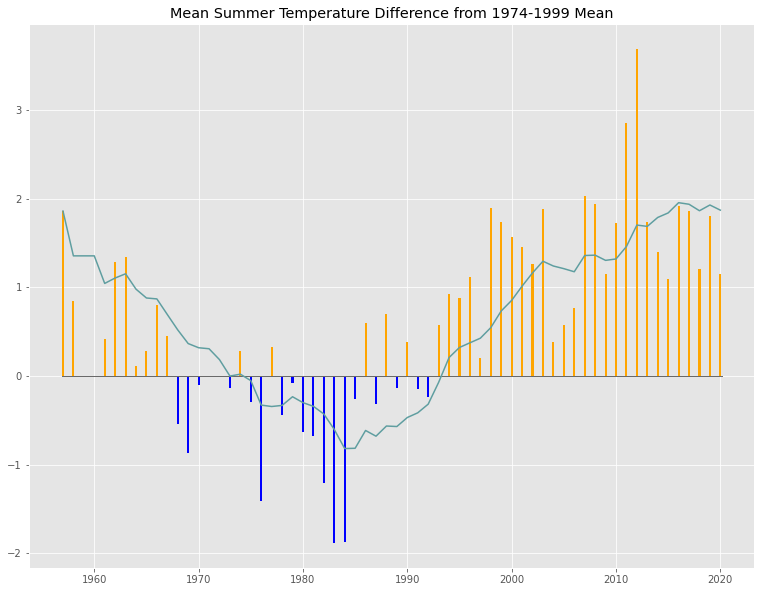

In [28]:
plt.style.use('ggplot')
plt.figure(figsize=(13, 10))
plt.title("Mean Summer Temperature Difference from 1974-1999 Mean")
plt.bar(summers_dev_from_base.index, 
        summers_dev_from_base, 
        width=0.2, 
        color=np.where(summers_dev_from_base < 0, 'blue', 'orange'),
        )
plt.axhline(xmin=0.045, xmax=0.955, color="dimgrey", linewidth=1) # for the line on the x axis
plt.plot(summers_roll_avg_dev.index, summers_roll_avg_dev, color="cadetblue")

### Interpretation
* The mean summer temperature fluctuated at relatively low levels in the period 1955-1995, and especially within 1964-1993.
* In the period 1996-2020 the mean summer temperature is almost every year a degree higher than the baseline temperature.
* Generally, the trend is upwards.
* A  relative steadiness can be noted in the period 2014-2020.

All the above observations can be explained by the increased human activity the latter years. The combustion of fuels and deforastation are only few causes of the problem. A positive insight is that the efforts against global change seem to yield results, flattening out the increase of the temperature, as the rolling average line indicates. 

## Evolution of Daily Temperatures
* Moving on we will create a plot showing the daily temperature of each year.
* This way we will get a better idea of the change in temperature through the years.
* *Note: in our plot we will use 30-day rolling averages, to smooth the lines.*

* Let's start by calculating the average temperature for each year for the full period from 1955 to 2020, to get a first picture.

In [29]:
avg_year_temp = df.groupby("year")["avg_temp"].mean()
avg_year_temp.head(5)

year
1955          NaN
1956          NaN
1957    21.271739
1958    18.710959
1959          NaN
Name: avg_temp, dtype: float64

* With the aim of depicting the general trend of the evolution of the temperature we will perform a simple linear regression.

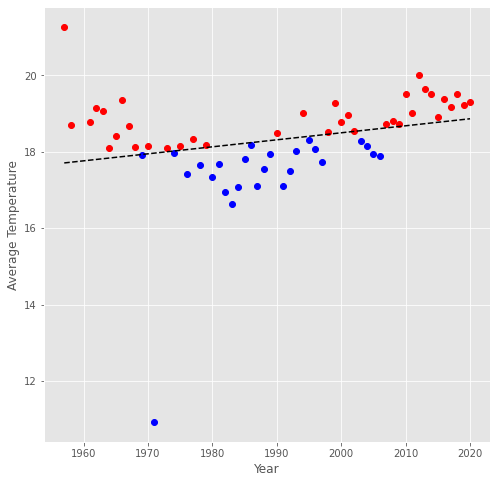

In [30]:
#https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
avg_year_temp_not_null = avg_year_temp[~ avg_year_temp.isnull()] # we use this in case we don't fill avg_temp with the average
                                                                 # of max and min
years = np.array(avg_year_temp_not_null.index)
coef = np.polyfit(years, np.array(avg_year_temp_not_null),1)
poly1d_fn = np.poly1d(coef)
is_year_hot = avg_year_temp_not_null > poly1d_fn(years)

plt.figure(figsize=(8, 8))
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.plot(years[is_year_hot], avg_year_temp_not_null[is_year_hot], "ro")
plt.plot(years[~ is_year_hot], avg_year_temp_not_null[~ is_year_hot], "bo")
plt.plot(years, poly1d_fn(years), '--k')

* We can easily observe that it semms like the temperature is increasing.
* This plot comes in alignment with our interpretation of the first graph we generated.

* Next, we will add to our dataframe a new column that will contain the 30-day rolling average temperature for each day

In [31]:
df["rolling_avg_temp"] = df["avg_temp"].rolling(30, min_periods=1).mean()
df[1000:1005]

,date,prcp,avg_temp,year,rolling_avg_temp
1000,1957-09-27,0.0,24.6,1957,24.846667
1001,1957-09-28,0.6,23.1,1957,24.700000
1002,1957-09-29,0.0,22.3,1957,24.516667
1003,1957-09-30,0.0,22.8,1957,24.380000
1004,1957-10-01,0.0,23.3,1957,24.263333


* Also a column that shows the day of the year for every observation will come in handy later.

In [32]:
df["day_of_year"] = df["date"].dt.dayofyear
df.head(5)

,date,prcp,avg_temp,year,rolling_avg_temp,day_of_year
0,1955-01-01,0.0,NaN,1955,NaN,1
1,1955-01-02,2.0,NaN,1955,NaN,2
2,1955-01-03,0.0,NaN,1955,NaN,3
3,1955-01-04,0.0,NaN,1955,NaN,4
4,1955-01-05,0.0,NaN,1955,NaN,5


* Intending to create a different plot for each year, it is convenient to group our data.

In [33]:
df_grouped_year = df.groupby("year")
for year, year_group in list(df_grouped_year)[:5]:
    print(year)
    print(year_group[:3])

1955
        date  prcp  avg_temp  year  rolling_avg_temp  day_of_year
0 1955-01-01   0.0       NaN  1955               NaN            1
1 1955-01-02   2.0       NaN  1955               NaN            2
2 1955-01-03   0.0       NaN  1955               NaN            3
1956
          date  prcp  avg_temp  year  rolling_avg_temp  day_of_year
365 1956-01-01   0.0       NaN  1956               NaN            1
366 1956-01-02   0.0       NaN  1956               NaN            2
367 1956-01-03   0.0       NaN  1956               NaN            3
1957
          date  prcp  avg_temp  year  rolling_avg_temp  day_of_year
731 1957-01-01   0.0       NaN  1957               NaN            1
732 1957-01-02   0.0       NaN  1957               NaN            2
733 1957-01-03   0.3       NaN  1957               NaN            3
1958
           date  prcp  avg_temp  year  rolling_avg_temp  day_of_year
1096 1958-01-01   0.0      12.1  1958         11.503333            1
1097 1958-01-02   0.0      11.8  1

* We will also use our baseline period, 1974-1999, as a yardstick.

In [34]:
baseline_period = df.loc[df["year"].isin(range(1974, 2000))] # all days from 1974-1999

* To get the average temperature of each yearday during our baseline we will first **pivot** our table.

In [35]:
base_avg_temp = baseline_period.pivot(index="year", columns="day_of_year", values="avg_temp")
base_avg_temp.head(5)

day_of_year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
1974,11.6,13.7,12.2,10.8,9.6,8.7,9.7,9.7,8.5,9.3,...,11.1,11.3,11.1,10.2,11.7,11.6,11.6,12.0,12.8,NaN
1975,8.7,7.5,7.8,7.2,7.7,8.9,10.9,12.9,7.6,5.8,...,8.3,10.1,12.3,9.5,7.1,8.7,9.6,9.7,10.8,NaN
1976,11.3,12.4,13.6,13.6,8.4,9.5,11.4,10.6,8.7,9.1,...,10.5,9.1,9.1,9.9,10.3,8.2,5.6,7.0,13.4,12.6
1977,10.2,9.1,9.1,7.4,6.2,6.7,6.6,7.3,9.4,10.2,...,7.6,7.3,9.7,10.2,7.5,7.9,12.1,15.0,14.2,NaN
1978,7.0,4.6,6.1,8.9,9.4,4.2,4.4,5.2,2.3,4.9,...,14.1,10.8,11.1,13.0,12.4,14.0,14.1,14.9,14.4,NaN


* Now we can calculate the average temperature of each yearday during the baseline period.

In [36]:
base_yearday_avg_temp = base_avg_temp.mean()
base_yearday_avg_temp.head(5)

day_of_year
1    10.365385
2    10.707692
3    10.207692
4     9.634615
5     9.919231
dtype: float64

* And as we mentioned before we will use a 30-day rolling average to smooth the line, that we will draw.

In [37]:
base_yearday_roll_avg_temp = base_yearday_avg_temp.rolling(30, min_periods=1).mean()
base_yearday_roll_avg_temp.head(5)

day_of_year
1    10.365385
2    10.536538
3    10.426923
4    10.228846
5    10.166923
dtype: float64

### Plot
* It is time to generate our plot!
* We will draw a different line for each year, the colors are ranging from ligth orange to dark orange, the darker the color, the latter the year.
* The black line is the average daily temperature for the baseline period of 1974-1999.

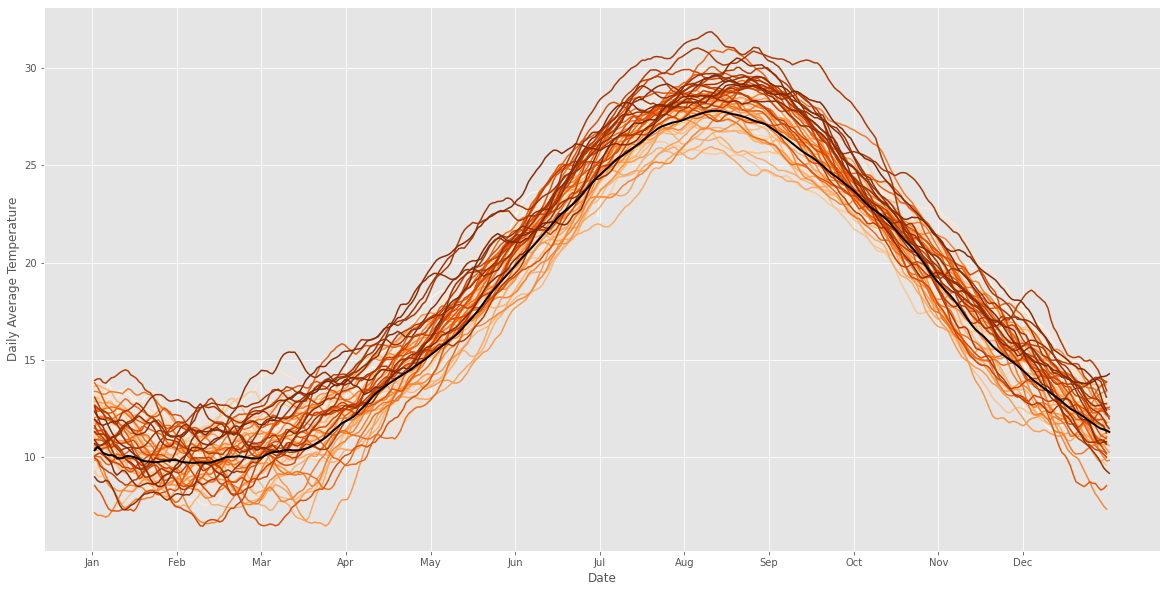

In [38]:
def get_oranges_for_plot(): # returns a dictionary, that contains the appropriate color for every year
    years = list(avg_year_temp_not_null.index) # we use again the avg_year_temp_not_null, we previously created,
                                               # to get the years that contain at least one avg_temp
    cmap = plt.get_cmap('Oranges')
    colors = [cmap(i) for i in np.linspace(0, 1, len(years))] # https://stackoverflow.com/questions/16006572/plotting-different-colors-in-matplotlib
    return dict(zip(years, colors)) # https://stackoverflow.com/questions/209840/how-do-i-convert-two-lists-into-a-dictionary
    
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.xlabel("Date")
plt.ylabel("Daily Average Temperature")
colors = get_oranges_for_plot()

for year, year_group in list(df_grouped_year):
    # we use this condition in case we don't fill avg_temp with the average of max and min and to plot only 
    # the years that contain at least one avg_temp
    if (year_group["avg_temp"].count() == 0):
        continue      
    plt.plot(year_group["day_of_year"], year_group["rolling_avg_temp"], color=colors[year])

# baseline plot
plt.plot(base_yearday_roll_avg_temp, color="black", linewidth=2)
# for the x axis months values
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
_ = plt.xticks(np.linspace(0,335,12), months) # assignment to _ is used in order to not print the list of matplotlib xticks 
                                              # (https://stackoverflow.com/questions/12056115/disable-the-output-of-matplotlib-pyplot)
                                              # also, here the year period is equally divided per month, but if we wanted more
                                              # accuracy we should use the appropriate space for each month.

### Interpretation
* Generally, darker colors are higher than the lighter ones, which means that the temperature has increased during the observed period.
* This trend isn't detected only a particular season, but through the whole year.
* An important increase of about 2.5 Celsius degrees can be noted the latter years relatively to the baseline.

These points generalize the interpretation we made in the previous sector, as it seems that the tendency of increasing temperature isn't detected only a certain period of the year.

## Extreme Temperature Events
* The number of extreme events is another measure that climatologists use. Extreme events are defined as those beyond 5% or 10% from the expected value.
* For our analysis, we will focus on the extreme heat events, that are 10% above the baseline.

* We have already calculated the average temperature of each yearday during our baseline period.
* That's what we will use as an expected value for each day of the year.

In [39]:
base_yearday_avg_temp.head(5)

day_of_year
1    10.365385
2    10.707692
3    10.207692
4     9.634615
5     9.919231
dtype: float64

* So the extreme temperature for each day is: expected value + 10% * |expected value|

In [40]:
yearday_extreme_temp = base_yearday_avg_temp.map(lambda x : x + 0.1 * abs(x))
yearday_extreme_temp.head(5)

day_of_year
1    11.401923
2    11.778462
3    11.228462
4    10.598077
5    10.911154
dtype: float64

* Before finding the number of extreme heat events per year, it is useful to pivot our dataset.

In [41]:
full_years_avg_temp = df.pivot(index="year", columns="day_of_year", values="avg_temp")
full_years_avg_temp.head(5)

day_of_year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.9,9.9,9.3,10.2,10.2,9.8,11.9,15.7,15.8,NaN
1958,12.1,11.8,12.1,10.3,8.5,10.2,13.6,15.6,7.8,5.8,...,16.8,16.4,15.3,12.9,13.6,12.4,13.5,11.2,9.0,NaN
1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* We will find the difference: average temperature - extreme temperature for all days.

In [42]:
diff_avg_extr = full_years_avg_temp - yearday_extreme_temp
diff_avg_extr.head(5)

day_of_year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.673846,-1.789615,-2.228846,-1.070769,-0.8,-1.487692,0.180769,3.587308,3.539231,NaN
1958,0.698077,0.021538,0.871538,-0.298077,-2.411154,-0.609615,2.439231,4.739615,-2.239615,-4.7468,...,4.226154,4.710385,3.771154,1.629231,2.6,1.112308,1.780769,-0.912692,-3.260769,NaN
1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* At this moment, we prefer the <code>diff_avg_extr</code> to have <code>day_of_year</code> as rows and <code>year</code> as columns.
* In this way, it is easier to exctract information for each year.
* So, we will transpose the table.

In [43]:
diff_avg_extr_t = diff_avg_extr.transpose()
diff_avg_extr_t.head(5)

year,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
day_of_year,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,0.698077,NaN,NaN,0.598077,1.498077,3.698077,-2.201923,...,-1.501923,-1.201923,-0.101923,-1.601923,-7.001923,-7.601923,-5.401923,-0.101923,-3.101923,-3.001923
2,NaN,NaN,NaN,0.021538,NaN,NaN,0.421538,1.921538,2.121538,-2.478462,...,-0.278462,-2.278462,-0.878462,-0.478462,-7.278462,-3.878462,-3.378462,1.921538,-4.378462,-4.678462
3,NaN,NaN,NaN,0.871538,NaN,NaN,2.371538,5.571538,1.971538,-3.628462,...,-0.228462,-1.528462,0.371538,-0.128462,-5.728462,0.271538,-0.128462,0.271538,-4.828462,-2.328462
4,NaN,NaN,NaN,-0.298077,NaN,NaN,3.201923,1.101923,5.801923,-0.198077,...,-0.798077,0.701923,0.601923,0.201923,0.501923,2.801923,1.201923,-0.998077,-4.898077,-0.198077
5,NaN,NaN,NaN,-2.411154,NaN,NaN,4.388846,-2.111154,4.088846,-2.211154,...,-1.611154,0.188846,0.388846,0.888846,-4.711154,6.288846,2.288846,-0.511154,-7.011154,-1.311154


* Now we can calculate the number of days with extreme average temperature for each year.
* An extreme heat event is a day that the difference: average temperature - extreme temperature is positive.

In [44]:
num_extreme_events = (diff_avg_extr_t > 0).sum()
num_extreme_events.head(5)

year
1955      0
1956      0
1957     50
1958    134
1959      0
dtype: int64

* Then, we will calculate the percentage of the extreme heat events over the number of observations for each year.
* We don't have the same number of observation for all years, so it's a better indicator.

In [45]:
pct_extreme_events = num_extreme_events / diff_avg_extr_t.count()
pct_extreme_events.head(5)

year
1955         NaN
1956         NaN
1957    0.271739
1958    0.367123
1959         NaN
dtype: float64

* Again for our plot we will use our baseline period as yardstick.
* For that purpose, we will calculate the average percentage of days with extreme temperature for the baseline period.

In [46]:
baseline_extreme_events_pct = pct_extreme_events[pct_extreme_events.index.isin(range(1974,2000))].mean()
baseline_extreme_events_pct

0.2481314415207134

### Plot
* We can now plot our data!

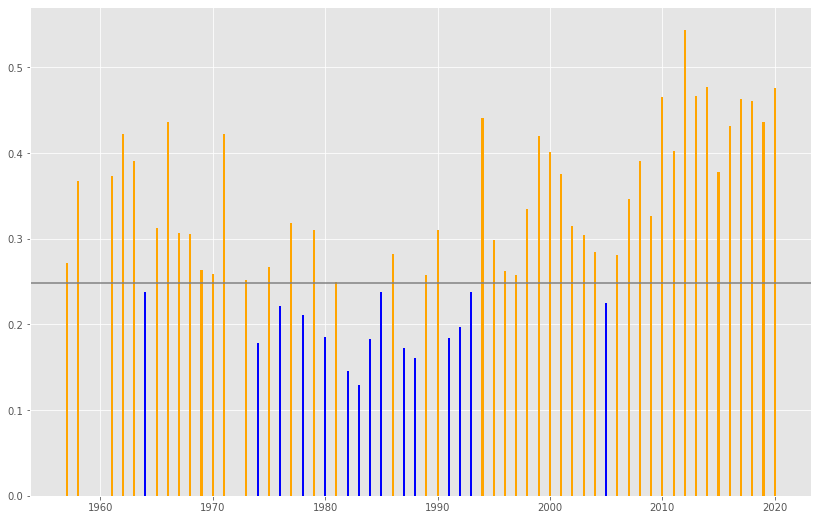

In [47]:
plt.style.use('ggplot')
plt.figure(figsize=(14, 9))

plt.bar(pct_extreme_events.index, pct_extreme_events ,width=0.184,
       color=np.where(pct_extreme_events < baseline_extreme_events_pct, 'blue', 'orange'))
plt.axhline(baseline_extreme_events_pct, color="gray")

### Normalization
* A problem with the procedure that we previously followed is the fact that we would get very different results, if we used another unit of measurement like Fahrehneit. That's because the 10% difference is related to the unit of measurement we use, as temperature units are not proportionally connected.
* A solution to this would be to normalize our data.
* We will use the formula x' = (x - xmin)/(xmax - xmin)
* In other respects, the procedure that we will follow is the same as before, so the only complemenatry text to our code will be a note: ***Normalization***, before every component that we will normalize our data.

Note: ***Normalization***

In [48]:
min_avg_temp = df.avg_temp.min()
max_avg_temp = df.avg_temp.max()
base_yearday_avg_temp_norm = (base_yearday_avg_temp - min_avg_temp)/ (max_avg_temp - min_avg_temp)
base_yearday_avg_temp_norm.head(5)

day_of_year
1    0.335105
2    0.344382
3    0.330832
4    0.315301
5    0.323014
dtype: float64

In [49]:
yearday_extreme_temp_norm = base_yearday_avg_temp_norm.map(lambda x : x + 0.1 * abs(x))
yearday_extreme_temp_norm.head(5)

day_of_year
1    0.368616
2    0.378820
3    0.363915
4    0.346831
5    0.355316
dtype: float64

Note: ***Normalization***

In [50]:
full_years_avg_temp_norm = (df.pivot(index="year", columns="day_of_year", values="avg_temp") - min_avg_temp)/ \
                            (max_avg_temp - min_avg_temp)
full_years_avg_temp_norm.head(5)

day_of_year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.295393,0.322493,0.306233,0.330623,0.330623,0.319783,0.376694,0.479675,0.482385,NaN
1958,0.382114,0.373984,0.382114,0.333333,0.284553,0.330623,0.422764,0.476965,0.265583,0.211382,...,0.509485,0.498645,0.468835,0.403794,0.422764,0.390244,0.420054,0.357724,0.298103,NaN
1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
diff_avg_extr_norm = full_years_avg_temp_norm - yearday_extreme_temp_norm
diff_avg_extr_norm.head(5)

day_of_year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.104982,-0.053919,-0.065822,-0.034438,-0.027100,-0.045737,-0.000521,0.091797,0.090494,NaN
1958,0.013498,-0.004836,0.018199,-0.013498,-0.070763,-0.021941,0.060684,0.123025,-0.066114,-0.13406,...,0.109110,0.122233,0.096779,0.038733,0.065041,0.024724,0.042839,-0.030154,-0.093788,NaN
1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
diff_avg_extr_norm_t = diff_avg_extr_norm.transpose()
diff_avg_extr_norm_t.head(5)

year,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
day_of_year,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,0.013498,NaN,NaN,0.010788,0.035178,0.094799,-0.065093,...,-0.046123,-0.037992,-0.008182,-0.048833,-0.195174,-0.211434,-0.151814,-0.008182,-0.089483,-0.086773
2,NaN,NaN,NaN,-0.004836,NaN,NaN,0.006004,0.046654,0.052074,-0.072587,...,-0.012966,-0.067167,-0.029227,-0.018386,-0.202668,-0.110527,-0.096977,0.046654,-0.124078,-0.132208
3,NaN,NaN,NaN,0.018199,NaN,NaN,0.058849,0.145570,0.048009,-0.103752,...,-0.011611,-0.046842,0.004649,-0.008901,-0.160663,0.001939,-0.008901,0.001939,-0.136273,-0.068522
4,NaN,NaN,NaN,-0.013498,NaN,NaN,0.081353,0.024442,0.151814,-0.010788,...,-0.027048,0.013602,0.010892,0.000052,0.008182,0.070513,0.027152,-0.032468,-0.138159,-0.010788
5,NaN,NaN,NaN,-0.070763,NaN,NaN,0.113519,-0.062633,0.105389,-0.065343,...,-0.049083,-0.000302,0.005118,0.018668,-0.133094,0.165009,0.056608,-0.019272,-0.195424,-0.040953


In [53]:
num_extreme_events_norm = (diff_avg_extr_norm_t > 0).sum()
num_extreme_events_norm.head(5)

year
1955      0
1956      0
1957     44
1958    120
1959      0
dtype: int64

In [54]:
pct_extreme_events_norm = num_extreme_events_norm / diff_avg_extr_t.count()
pct_extreme_events.head(5)

year
1955         NaN
1956         NaN
1957    0.271739
1958    0.367123
1959         NaN
dtype: float64

In [55]:
baseline_extreme_events_pct_norm = pct_extreme_events_norm[pct_extreme_events_norm.index.isin(range(1974,2000))].mean()
baseline_extreme_events_pct_norm

0.2252633164945334

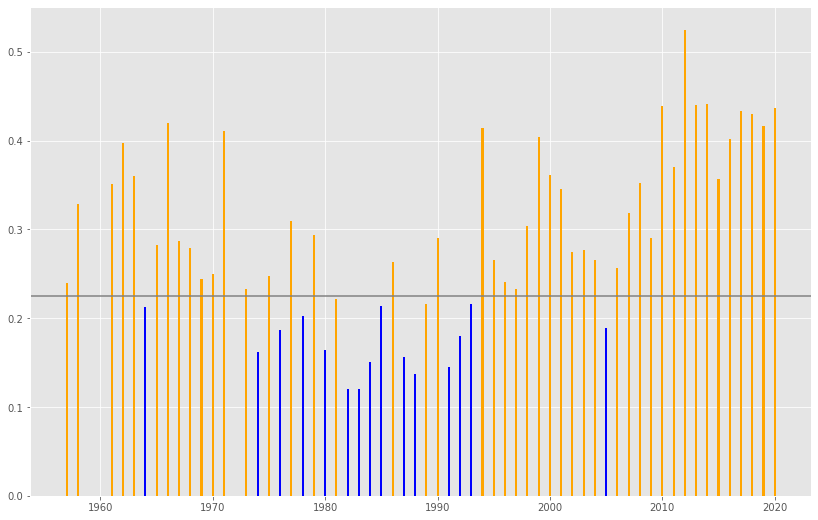

In [56]:
plt.style.use('ggplot')
plt.figure(figsize=(14, 9))

plt.bar(pct_extreme_events_norm.index, pct_extreme_events_norm ,width=0.184,
       color=np.where(pct_extreme_events < baseline_extreme_events_pct, 'blue', 'orange'))
plt.axhline(baseline_extreme_events_pct_norm, color="gray")

### Interpretation
* Extreme events between 1973-1993 are relativley low.
* But, the percentage of extreme events per year after 1993 is significantly larger.

It looks like the climate change is connected with extreme weather, or, at least, increase in extreme heat events. That is a serious problem, as it does not only cause problems in human living, but also disturbs the smooth operation of different ecosystems.

## Precipitation
* We will also study the precipitation in the period 1955-2020.
* More specifically, we will focus on the ratio of rainfall over rainy days over the years.

* Again we will use <code>pivot</code>, but this time for the precipitation.
* We want <code>day_of_year</code> as index and <code>year</code> as columns.

In [57]:
full_years_prcp = df.pivot(index="day_of_year", columns="year", values="prcp")
full_years_prcp.head(5)

year,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
day_of_year,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,0.0,0.1,...,0.0,0.0,0.0,8.4,1.4,0.0,0.0,0.0,68.3,0.0
2,2.0,0.0,0.0,0.0,5.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.2,0.0,0.5,0.0,0.0,0.0,1.5
3,0.0,0.0,0.3,0.0,5.7,5.6,0.0,0.0,0.0,0.0,...,18.8,0.0,0.2,0.0,0.0,2.2,0.0,1.0,0.5,3.3
4,0.0,0.0,4.0,0.0,0.0,23.8,0.0,0.0,0.0,13.4,...,6.1,0.0,0.0,0.0,0.0,0.0,0.0,0.3,10.4,0.0
5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.8,0.0


* It is also necessary to calculate the number of rainy days for each year
* A rainy day is a day that its precipitation is larger than zero.

In [58]:
num_rainy_days = (full_years_prcp > 0).sum()
num_rainy_days.head(5)

year
1955    68
1956    52
1957    73
1958    68
1959    62
dtype: int64

* We must also calculate the total precipitation for every year.

In [59]:
total_prcp = full_years_prcp.sum()
total_prcp.head(5)

year
1955    547.0
1956    281.3
1957    303.2
1958    350.0
1959    214.0
dtype: float64

* And now we can find the average precipitation per year.

In [60]:
avg_prcp = total_prcp / num_rainy_days
avg_prcp.head(5)

year
1955    8.044118
1956    5.409615
1957    4.153425
1958    5.147059
1959    3.451613
dtype: float64

* We will also plot a line of the 10 years rolling average.

In [61]:
roll_avg_prcp = avg_prcp.rolling(10, min_periods=1).mean()
roll_avg_prcp.head(5)

year
1955    8.044118
1956    6.726867
1957    5.869053
1958    5.688554
1959    5.241166
dtype: float64

### Plot
* We have now calcuated everything we need for our plot!

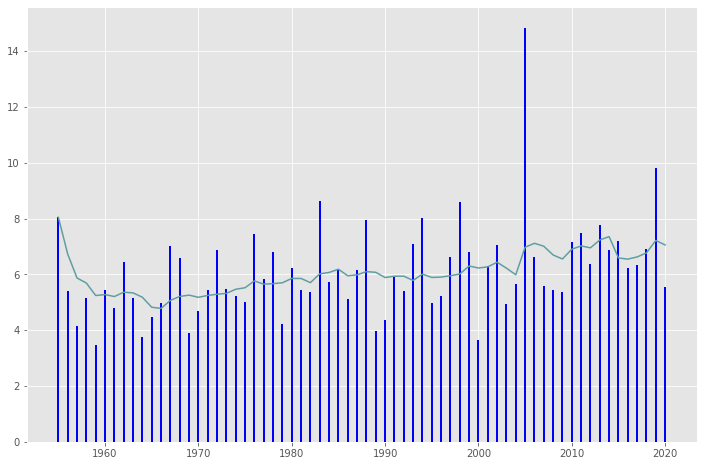

In [62]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))

plt.bar(avg_prcp.index, 
        avg_prcp,
        width = 0.21,
        color='blue')
plt.plot(roll_avg_prcp, color="cadetblue")

### Interpretation
* AS the 10 year rolling average shows, the average precipitation slowing increases as the years pass.
* Especially, the last 10 years the average precipitation is almost exclusively above 6 mm, while the previous years this was far more rare.

As we concluded before the weather seems to become more extreme, as a rusult of the climate change. Here we can see that we are getting rain in more concentrated bursts. Also, the data show that the weather